## Accessing Daymet data with the Planetary Computer STAC API

The [Daymet](https://daymet.ornl.gov/) dataset contains daily minimum temperature, maximum temperature, precipitation, shortwave radiation, vapor pressure, snow water equivalent, and day length at 1km resolution for North America, Hawaii, and Puerto Rico. Annual and monthly summaries are also available. The dataset covers the period from January 1, 1980 to December 31, 2020.

Daymet is available in both NetCDF and Zarr format on Azure; this notebook demonstrates using the Planetary Computer STAC API to access to the Zarr data, which can be read into an [xarray](http://xarray.pydata.org/en/stable/) [Dataset](http://xarray.pydata.org/en/stable/data-structures.html#dataset). If you just need a subset of the data, we recommend using xarray and Zarr to avoid downloading the full dataset unnecessarily.

More complete documentation is available on the [Planetary Computer data catalog](https://planetarycomputer.microsoft.com/dataset/group/daymet).

### Environment setup

In [1]:
import cartopy.crs as ccrs
import fsspec
import matplotlib.pyplot as plt
import pystac
import xarray as xr
import warnings

from dask.distributed import Client

warnings.simplefilter("ignore", RuntimeWarning)

### Data access

There are 9 STAC Collections representing the unique combination of the 3 regions (`na`, `hi`, `pr`) and 3 frequencies (`daily`, `monthly`, `annual`), each prefixed with the `daymet` key. For example, `daymet-monthly-na` or `daymet-annual-pr`. Each collection contains all the metadata necessary to load the dataset with xarray, and can be read by [PySTAC](https://pystac.readthedocs.io/en/latest/).

Let's start by loading the daily data for Hawaii.

In [2]:
# TODO: remove staging
url = (
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1/collections/"
    "daymet-daily-hi"
)
collection = pystac.read_file(url)
collection

<Collection id=daymet-daily-hi>

The collection contains assets, which are links to the root of a Zarr store, and can be opened with xarray.

In [3]:
asset = collection.assets["zarr-https"]
asset

<Asset href=https://daymeteuwest.blob.core.windows.net/daymet-zarr/daily/hi.zarr>

In [4]:
store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14965, x: 284, y: 584)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(584, 284), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(584, 284), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 20...
  * x                        (x) float32 -5.802e+06 -5.801e+06 ... -5.519e+06
  * y                        (y) float32 -3.9e+04 -4e+04 ... -6.21e+05 -6.22e+05
Dimensions without coordinates: nv
Data variables:
    dayl                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    srad                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(365, 584, 284), meta=np.ndarray>
    yearday                  (time) int16 dask.array<chunksize=(365,), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        1980

### Working with the data

Using xarray, we can quickly select subsets of the data, perform an aggregation, and plot the result. For example, we'll plot the average of the maximum temperature for the year 2020. We can tell xarray to keep the attributes from the Dataset on the resulting DataArray.

In [5]:
xr.set_options(keep_attrs=True)

avg_tmax = ds.sel(time="2020")["tmax"].mean(dim="time")
avg_tmax

<xarray.DataArray 'tmax' (y: 584, x: 284)>
dask.array<mean_agg-aggregate, shape=(584, 284), dtype=float32, chunksize=(584, 284), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(584, 284), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(584, 284), meta=np.ndarray>
  * x        (x) float32 -5.802e+06 -5.801e+06 -5.8e+06 ... -5.52e+06 -5.519e+06
  * y        (y) float32 -3.9e+04 -4e+04 -4.1e+04 ... -6.21e+05 -6.22e+05
Attributes:
    cell_methods:  area: mean time: maximum
    grid_mapping:  lambert_conformal_conic
    long_name:     daily maximum temperature
    units:         degrees C

Pull the Coordinate Reference System (CRS) out from the dataset attributes and plot the variable in a geographic projection. 

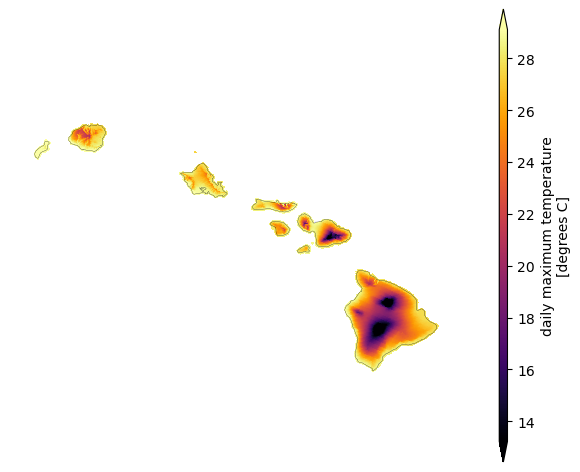

In [6]:
lcc = ds.variables["lambert_conformal_conic"].attrs

prj_kwargs = dict(
    central_latitude=lcc["latitude_of_projection_origin"],
    central_longitude=lcc["longitude_of_central_meridian"],
    standard_parallels=(lcc["standard_parallel"]),
)
crs = ccrs.LambertConformal(**prj_kwargs)

fig = plt.figure(figsize=(10, 6), dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree(), frameon=False)
avg_tmax.plot(
    ax=ax, transform=crs, cmap="inferno", cbar_kwargs={"aspect": 50}, robust=True
)
ax.coastlines(linewidth=0.2)
plt.show()

Next, we can visualize the timeseries of the minimum temperature over the past decade.

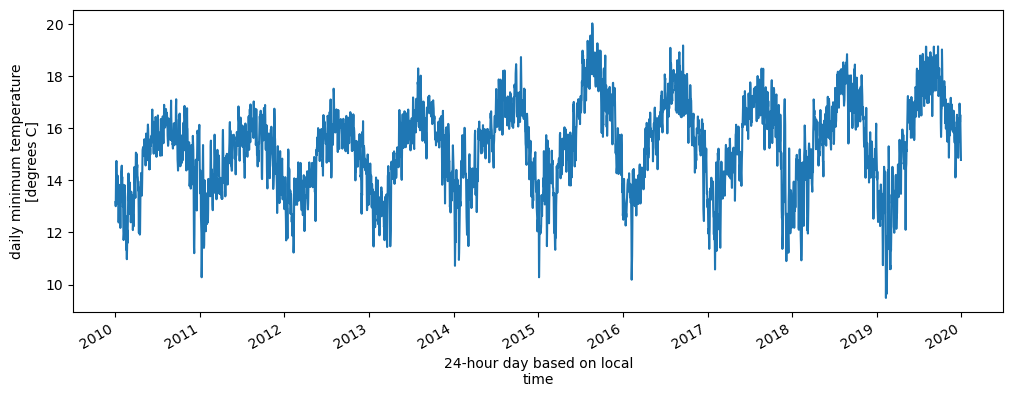

In [7]:
fig, ax = plt.subplots(figsize=(12, 4), dpi=100)
ds.sel(time=slice("2010", "2019"))["tmin"].mean(dim=["x", "y"]).plot(ax=ax);

### Chunking

Each of the datasets is chunked to allow for parallel and out-of-core or distributed processing with [Dask](https://dask.org/). The different frequencies (`daily`, `monthly`, `annual`) are chunked so that each year is in a single chunk. The different regions in the `x` and `y` coordinates are chunked so that no single chunk is larger than about 250 MB, which is primarily important for the `na` region.

In [8]:
ds["prcp"]

<xarray.DataArray 'prcp' (time: 14965, y: 584, x: 284)>
dask.array<open_dataset-ceacc5c4ce43f8b606a5fa26f740e512prcp, shape=(14965, 584, 284), dtype=float32, chunksize=(365, 584, 284), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(584, 284), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(584, 284), meta=np.ndarray>
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 2020-12-30T12:00:00
  * x        (x) float32 -5.802e+06 -5.801e+06 -5.8e+06 ... -5.52e+06 -5.519e+06
  * y        (y) float32 -3.9e+04 -4e+04 -4.1e+04 ... -6.21e+05 -6.22e+05
Attributes:
    cell_methods:  area: mean time: sum
    grid_mapping:  lambert_conformal_conic
    long_name:     daily total precipitation
    units:         mm/day

So our `prcp` array has a shape `(14965, 584, 284)` where each chunk is `(365, 584, 284)`. Examining the store for monthly North America, we see the chunks each have size `(12, 2000, 2000)`. 

In [9]:
# TODO: remove staging
na_url = (
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1/collections/"
    "daymet-monthly-na"
)
na_collection = pystac.read_file(na_url)
na_asset = na_collection.assets["zarr-https"]

na_store = fsspec.get_mapper(na_asset.href)
na = xr.open_zarr(na_store, **na_asset.extra_fields["xarray:open_kwargs"])

na["prcp"]

<xarray.DataArray 'prcp' (time: 492, y: 8075, x: 7814)>
dask.array<open_dataset-b035586412ee4bf4ccfa543a2a7d2306prcp, shape=(492, 8075, 7814), dtype=float32, chunksize=(12, 2000, 2000), chunktype=numpy.ndarray>
Coordinates:
    lat      (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
    lon      (y, x) float32 dask.array<chunksize=(2000, 2000), meta=np.ndarray>
  * time     (time) datetime64[ns] 1980-01-16T12:00:00 ... 2020-12-16
  * x        (x) float32 -4.56e+06 -4.559e+06 -4.558e+06 ... 3.252e+06 3.253e+06
  * y        (y) float32 4.984e+06 4.983e+06 4.982e+06 ... -3.089e+06 -3.09e+06
Attributes:
    cell_methods:  area: mean time: sum within days time: sum over days
    grid_mapping:  lambert_conformal_conic
    long_name:     monthly total precipitation
    units:         mm

### Analyze and plot North America

North America is considerably larger than the Hawaii or Puerto Rico dataset, so let's downsample a bit for quicker plotting. We'll also start up a local Dask cluster to do reads and processing in parallel. If you're running this on the Hub, use the following URL in the Dask Extension to see progress.

In [10]:
client = Client(processes=False)
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


In [11]:
na_prcp = (
    na["prcp"]
    .sel(time="2020-06")
    .coarsen(dim={"x": 4, "y": 4}, boundary="trim")
    .mean()
    .load()
)

First, grab monthly total precipitation from June 2020 and plot it over the continent to get a sense of the distribution.

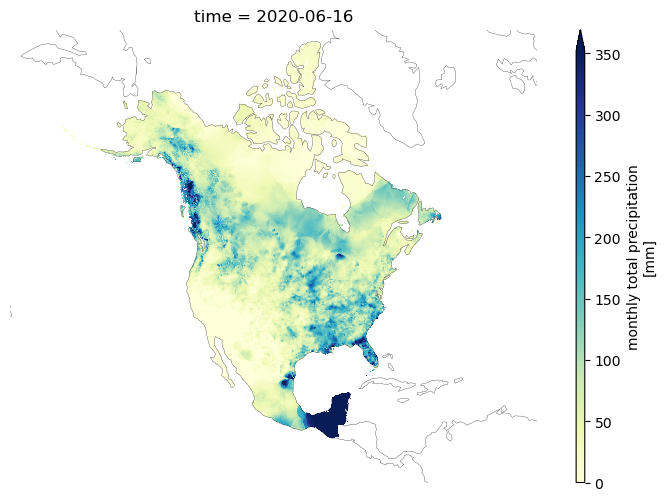

In [12]:
fig, ax = plt.subplots(
    figsize=(10, 6), dpi=100, subplot_kw=dict(projection=crs, frameon=False)
)
na_prcp.plot(
    ax=ax, transform=crs, cmap="YlGnBu", cbar_kwargs={"aspect": 50}, robust=True
)
ax.set_extent([-145, -58, 5, 84])
ax.coastlines(linewidth=0.2)
plt.show()

The dataset contains a lot of months. Let's compute the average precipition over the whole continent for each month in the last 20 years. From that, we'll grab the top 6 wettest months and plot them. 

In [13]:
%%time

total_avg_prcp = na["prcp"].isel(time=slice(-12 * 20, None)).mean(["x", "y"]).load()
df = total_avg_prcp.to_dataframe()
top6 = df.sort_values("prcp", ascending=False).head(6)
top6

CPU times: user 2min 22s, sys: 1min 9s, total: 3min 32s
Wall time: 1min 43s


,prcp
time,
2010-07-16 12:00:00,95.606590
2016-08-16 12:00:00,91.286697
2008-07-16 12:00:00,88.666389
2013-09-16 00:00:00,87.022514
2008-08-16 12:00:00,86.610909
2010-09-16 00:00:00,85.655731


CPU times: user 28.1 s, sys: 9.32 s, total: 37.4 s
Wall time: 21.5 s


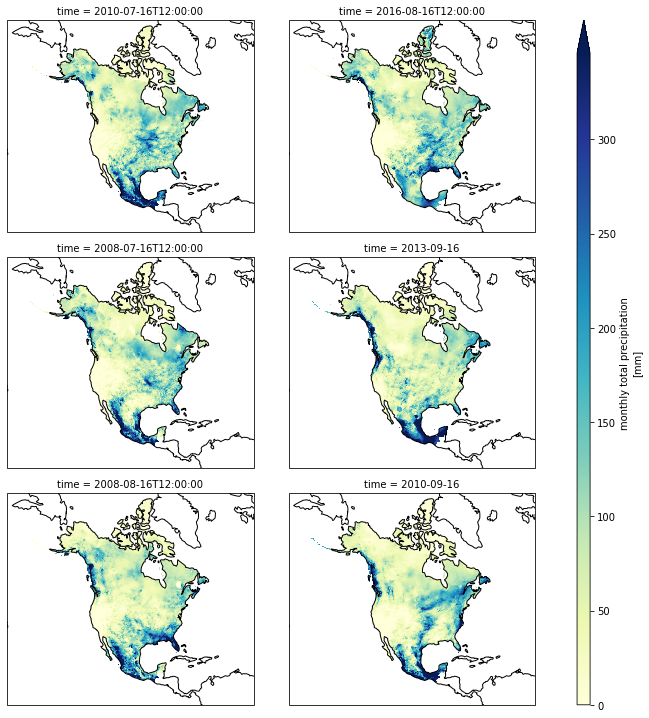

In [14]:
%%time

wettest_months = top6.index.to_list()
da = (
    na["prcp"]
    .sel(time=wettest_months)
    .coarsen(dim={"x": 8, "y": 8}, boundary="trim")
    .mean()
)
p = da.plot(
    col="time",
    col_wrap=2,
    figsize=(12, 10),
    cmap="YlGnBu",
    robust=True,
    subplot_kws=dict(projection=crs),
    cbar_kwargs={"aspect": 50},
)

for ax in p.axes.flat:
    ax.set_extent([-145, -58, 5, 84])
    ax.coastlines()